Reactions, without water with r_c=0.66

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import collections
import functools
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_context('poster')
sns.set_style('white')
sns.set_palette('Paired', 25)
colors = sns.color_palette('Paired', 25)

# PDI

In [4]:
no_water_polstat = []
for f in os.listdir('.'):
    if f.startswith('polstat'):
        d = np.loadtxt(f)
        no_water_polstat.append(d)

cr = 0.001
scan_p0_1000_nowater = collections.defaultdict(list)
for f in sorted(os.listdir('../scan_p_1000/no_water/')):
    if f.startswith('polstat'):
        k = float(f.split('_')[2])
        if k != cr:
            continue
        d = np.loadtxt(os.path.join('../scan_p_1000/no_water/', f))
        header = open(os.path.join('../scan_p_1000/no_water/', f)).readline().replace('#', '').split()
        d.dtype = [(x, 'float') for x in header]
        scan_p0_1000_nowater[k].append(d)

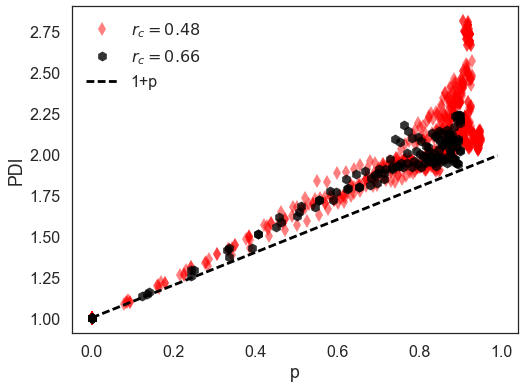

In [14]:
plt.rcParams['figure.figsize'] = (8, 6)
for l in scan_p0_1000_nowater[cr]:
    x = (l['cr']/2000.0)
    y = l['pdi']
    c, = plt.plot(x, y, 'rd', markevery=100, alpha=0.5, label=r'$r_c=0.48$', markersize=10.0)
for d in no_water_polstat:
    nc, = plt.plot(d[:, 0]/2000.0, d[:, 7], label=r'$r_c=0.66$', color='k', marker='h', alpha=0.8, markersize=10.0, linestyle='None', markevery=50)
th, = plt.plot(np.arange(0.0, 1.0, 0.01), 1+np.arange(0.0, 1.0, 0.01), 'k--', label='1+p')
plt.ylabel('PDI')
plt.xlabel('p')
plt.legend((c, nc, th), (r'$r_c=0.48$', r'$r_c=0.66$', '1+p'), loc=0)

# Kinetics

In [32]:
states_no_water = collections.defaultdict(dict)
nb_no_water = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E'}
path = '.'
for f in os.listdir(path):
    if f.startswith('states_'):
        p = f.split('_')[3]
        code = f.split('_')[1]
        if code not in t2name:
            continue
        t = t2name[f.split('_')[1]]
        d = np.loadtxt(os.path.join(path, f))
        print(f, d.shape)
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_no_water[p]:
            states_no_water[p][t] = []
        states_no_water[p][t].append(d)
    elif f.startswith('nb_'):
        p = f.split('_')[6]
        t = f.split('_')[4]
        nb_no_water[p][t] = np.loadtxt(os.path.join(path, f))
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

states_t0_p_0.001_845000_0.95_845000_traj_sim.csv (2284, 4)
states_t0_p_0.001_356667_0.95_356667_traj_sim.csv (2125, 4)
states_t1_p_0.001_573735_0.95_573735_traj_sim.csv (2108, 4)
states_t3_p_0.001_356667_0.95_356667_traj_sim.csv (2125, 4)
states_t4_p_0.001_573735_0.95_573735_traj_sim.csv (2108, 4)
states_t1_p_0.001_845000_0.95_845000_traj_sim.csv (2284, 4)
states_t0_p_0.001_573735_0.95_573735_traj_sim.csv (2108, 4)
states_t3_p_0.001_573735_0.95_573735_traj_sim.csv (2108, 4)
states_t4_p_0.001_845000_0.95_845000_traj_sim.csv (2284, 4)
states_t1_p_0.001_356667_0.95_356667_traj_sim.csv (2125, 4)
states_t4_p_0.001_356667_0.95_356667_traj_sim.csv (2125, 4)
states_t3_p_0.001_845000_0.95_845000_traj_sim.csv (2284, 4)


In [19]:
avg_states_no_water = collections.defaultdict(dict)
std_states_no_water = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3, 'B': 2}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2}

for p, p_ts in states_no_water.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_no_water[p][t] = av
        std_states_no_water[p][t] = np.std(tmp_l, axis=0)

In [29]:
avg_states_no_water['0.001']['A'].shape

(2108, 4)

In [20]:
def f_1(y, t):
    s0 = y[0]
    s1 = y[1]
    s2 = y[2]
    k0 = 0.0001
    k1 = 0.0001
    k2 = 0.0001
    
    ds2dt = -k2*s2
    ds1dt = -k1*s1 + k2*s2
    ds0dt = k1*s1
    
    return np.array([ds0dt, ds1dt, ds2dt])

In [71]:
cr = '0.001'
tD = avg_states_no_water[cr]['D']
tA = avg_states_no_water[cr]['A']
tC = avg_states_no_water[cr]['C']
tE = avg_states_no_water[cr]['E']

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(tE[:, 0][0], tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2
    dcdt = k*a**2
    
    return np.array([dadt, dcdt])

t0 = np.linspace(tE[:, 0][0], tE[:, 0][-1], 50)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(3.6*float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.0*float(cr),))

/home/teodor/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


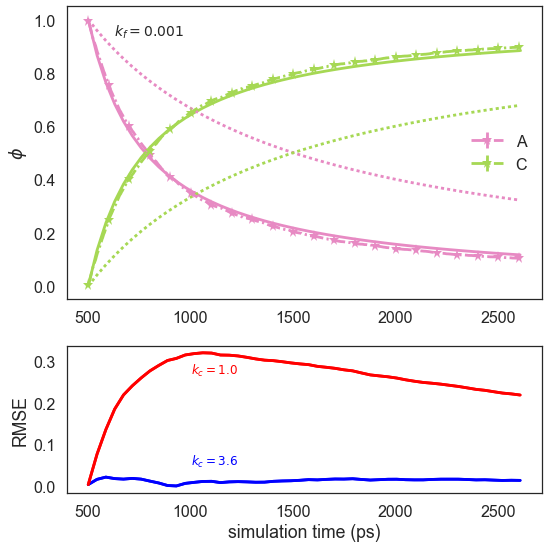

In [72]:
plt.rcParams['figure.figsize'] = (8, 8)
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

a0.errorbar(tA[:, 0], tA[:, 2]/2000.0, std_states_no_water[cr]['A'][:, 2]/2000.0, errorevery=100, 
             linestyle='-.', marker='*', markevery=100, label='A', color=sns.color_palette('Set2', 6)[3])
a0.errorbar(tC[:, 0], tC[:, 1]/2000.0, std_states_no_water[cr]['C'][:, 1]/2000.0, errorevery=100, 
             linestyle='-.', marker='*', markevery=100, label='C', color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac[:, 0], color=sns.color_palette('Set2', 6)[3])
a0.plot(t0, y_ac[:, 1], color=sns.color_palette('Set2', 6)[4])
a0.plot(t0, y_ac_raw[:, 0], color=sns.color_palette('Set2', 6)[3], linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color=sns.color_palette('Set2', 6)[4], linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.1, 0.9), xycoords='axes fraction', fontsize=14)

a0.set_ylabel(r'$\phi$')
#a0.set_xlim([500, 7000])(0
a0.legend(loc=0)


fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)

t0 = np.linspace(tA[:, 0][0], tA[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')

t0 = np.linspace(tC[:, 0][0], tC[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')

t0 = np.linspace(tA[:, 0][0], tA[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')

t0 = np.linspace(tC[:, 0][0], tC[:, 0][-1], 50)
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')

a1.annotate(r'$k_c=1.0$', xy=(1000, 0.27), fontsize=12, color='r')
a1.annotate(r'$k_c=3.6$', xy=(1000, 0.05), fontsize=12, color='b')

a1.legend(loc=0)
#a1.set_xlim([500, 7000])
a1.set_ylabel('RMSE')
a1.set_xlabel('simulation time (ps)')

f.tight_layout()

# Number of neighbours

In [56]:
nb_data = {}
for f in os.listdir('.'):
    if f.startswith('nb'):
        d = np.loadtxt(f)
        t = f.split('_')[5]
        nb_data[t] = d

1.09340385603
1.07827653815
1.03867112588


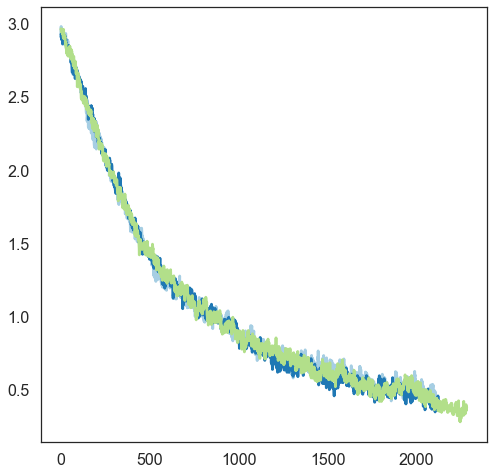

In [60]:
for k in nb_data:
    d = nb_data[k]
    print(np.average(d[:, 1]))
    plt.plot(d[:, 0], d[:, 1])